In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tifffile
import tensorflow as tf
from skimage import color
from skimage import transform

root_dir = Path("/home/hadim/.data/Neural_Network/Mask-RCNN/Microtubules/")
saved_model_dir = root_dir / "saved_model"

model_name = "coco_512_new"

# Configurations of the model
BATCH_SIZE = 1

IMAGE_RESIZE_MODE = "square"
IMAGE_MIN_DIM = 10
IMAGE_MAX_DIM = 512
MIN_SCALE = 1
MEAN_PIXEL = [123.7, 116.8, 103.9]
CLASS_IDS = ["BG", "microtubule"]
IMAGE_SHAPE = [IMAGE_MAX_DIM, IMAGE_MAX_DIM, 3]

BACKBONE = "resnet50"
BACKBONE_STRIDES = [4, 8, 16, 32, 64]
RPN_ANCHOR_SCALES = [8, 16, 32, 64, 128]
RPN_ANCHOR_RATIOS = [0.5, 1, 2]
RPN_ANCHOR_STRIDE = 1

INPUT_NODE_IMAGE_NAME = "input_image"
INPUT_NODE_IMAGE_METADATA_NAME = "input_image_meta"
INPUT_NODE_ANCHORS_NAME = "input_anchors"
OUTPUT_NODE_NAMES = ["detections", "mrcnn_class", "mrcnn_bbox", "mrcnn_mask", "rois"]

tf_model_path = saved_model_dir / f"tf_model_{model_name}.pb"
assert tf_model_path.is_file()

preprocessing_model_path = saved_model_dir / "preprocessing_graph.pb"
postprocessing_model_path = saved_model_dir / "postprocessing_graph.pb"

def get_tensor(graph, name, suffix=":0"):
    return graph.get_tensor_by_name(f"{name}{suffix}")

/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load an image

(512, 512)

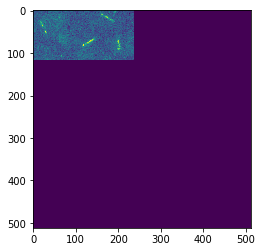

In [2]:
image_dir = Path("/home/hadim/Documents/Code/Postdoc/ij/testdata/")
image_path = image_dir / "fake-flat-corrected.tif"
image_path = image_dir / "7,5uM_emccd_lapse1-small-8bit-Single.tif"
#image_path = image_dir / "test-tracking-single.tif"
#image_path = image_dir / "test-tracking.tif"

original_images = tifffile.imread(str(image_path))
if len(original_images.shape) == 2:
    original_images = np.expand_dims(original_images, 0)

original_image = original_images[0]
padded_image = np.pad(original_image, [(0, IMAGE_MAX_DIM - original_image.shape[0]),
                                       (0, IMAGE_MAX_DIM - original_image.shape[1])],
                      mode='constant', constant_values=0)

plt.imshow(padded_image)
padded_image.shape

# Preprocessing

In [3]:
# Load preprocessing graph
with tf.gfile.FastGFile(str(preprocessing_model_path), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.reset_default_graph()
    tf.import_graph_def(graph_def, name='')

# Do preprocessing
with tf.Session() as sess:
  
    # Declare inputs
    image = get_tensor(sess.graph, "input_image")
    h = get_tensor(sess.graph, "original_image_height")
    w = get_tensor(sess.graph, "original_image_width")
    min_dim = get_tensor(sess.graph, "image_min_dimension")
    max_dim = get_tensor(sess.graph, "image_max_dimension")
    min_scale = get_tensor(sess.graph, "minimum_scale")
    mean_pixels = get_tensor(sess.graph, "mean_pixels")
    class_ids = get_tensor(sess.graph, "class_ids")
    backbone_strides = get_tensor(sess.graph, "backbone_strides")
    rpn_anchor_scales = get_tensor(sess.graph, "rpn_anchor_scales")
    rpn_anchor_ratios = get_tensor(sess.graph, "rpn_anchor_ratios")
    rpn_anchor_stride = get_tensor(sess.graph, "rpn_anchor_stride")
    
    feed_dict = {image: padded_image,
                 h: original_image.shape[0],
                 w: original_image.shape[1],
                 min_dim: IMAGE_MIN_DIM,
                 max_dim: IMAGE_MAX_DIM,
                 min_scale: MIN_SCALE,
                 mean_pixels: MEAN_PIXEL,
                 class_ids: np.zeros([len(CLASS_IDS)], dtype=np.int32),
                 backbone_strides: BACKBONE_STRIDES,
                 rpn_anchor_scales: RPN_ANCHOR_SCALES,
                 rpn_anchor_ratios: RPN_ANCHOR_RATIOS,
                 rpn_anchor_stride: RPN_ANCHOR_STRIDE}
    
    # Declare outputs   
    fetches = {"molded_image": get_tensor(sess.graph, "molded_image"),
               "image_metadata": get_tensor(sess.graph, "image_metadata"),
               "window": get_tensor(sess.graph, "window"),
               "anchors": get_tensor(sess.graph, "anchors")}
    
    preprocessing_results = sess.run(fetches, feed_dict=feed_dict)

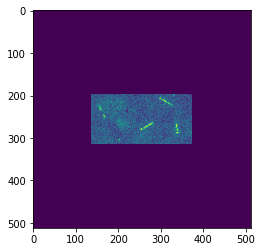

In [4]:
plt.imshow(preprocessing_results["molded_image"][:, :, 0])

# Load Model and Run Prediction

In [5]:
# Load Mask-RCNN model
with tf.gfile.FastGFile(str(tf_model_path), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.reset_default_graph()
    tf.import_graph_def(graph_def, name='')
    
# Prepare inputs
molded_images = [preprocessing_results["molded_image"]]
image_metas = [preprocessing_results["image_metadata"]]
anchors = [preprocessing_results["anchors"]]

with tf.Session() as sess:
    
    # Prepare inputs and outputs
    input_image_tensor = get_tensor(sess.graph, INPUT_NODE_IMAGE_NAME)
    input_image_metadat_tensor = get_tensor(sess.graph, INPUT_NODE_IMAGE_METADATA_NAME)
    input_anchor_tensor = get_tensor(sess.graph, INPUT_NODE_ANCHORS_NAME)
    
    input_data = {input_image_tensor: molded_images,
                  input_image_metadat_tensor: image_metas,
                  input_anchor_tensor: anchors}

    output_data = {node_name: get_tensor(sess.graph, f'output_{node_name}')
                   for node_name in OUTPUT_NODE_NAMES}
    
    # Run the prediction
    raw_results = sess.run(fetches=output_data, feed_dict=input_data)

# Do postprocessing

In [6]:
# Load preprocessing graph
with tf.gfile.FastGFile(str(postprocessing_model_path), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.reset_default_graph()
    tf.import_graph_def(graph_def, name='')

In [7]:
with tf.Session() as sess:
  
    # Declare inputs
    detections = get_tensor(sess.graph, "detections")
    mrcnn_mask = get_tensor(sess.graph, "mrcnn_mask")
    original_image_shape = get_tensor(sess.graph, "original_image_shape")
    image_shape = get_tensor(sess.graph, "image_shape")
    window = get_tensor(sess.graph, "window")
    
    feed_dict = {detections: raw_results["detections"][0],
                 mrcnn_mask: raw_results["mrcnn_mask"][0],
                 original_image_shape: list(original_images.shape[1:3]) + [1],
                 image_shape: IMAGE_SHAPE,
                 window: preprocessing_results["window"]}
    
    # Declare outputs   
    fetches = {"rois": get_tensor(sess.graph, "rois"),
               "class_ids": get_tensor(sess.graph, "class_ids"),
               "scores": get_tensor(sess.graph, "scores"),
               "masks": get_tensor(sess.graph, "masks")}
    
    postprocessing_results = sess.run(fetches, feed_dict=feed_dict)
    
postprocessing_results["rois"]

array([[ 47,  27,  57,  35],
       [ 24,  15,  40,  26],
       [ 64, 114,  87, 148],
       [  8, 160,  29, 192],
       [104,  63, 114,  69],
       [  0, 189,   8, 197],
       [ 67, 197,  91, 205],
       [  5, 158,  14, 165],
       [105,  42, 112,  49],
       [ 90, 196,  95, 207],
       [ 58,  61,  65,  70]], dtype=int32)

# Display result of detection

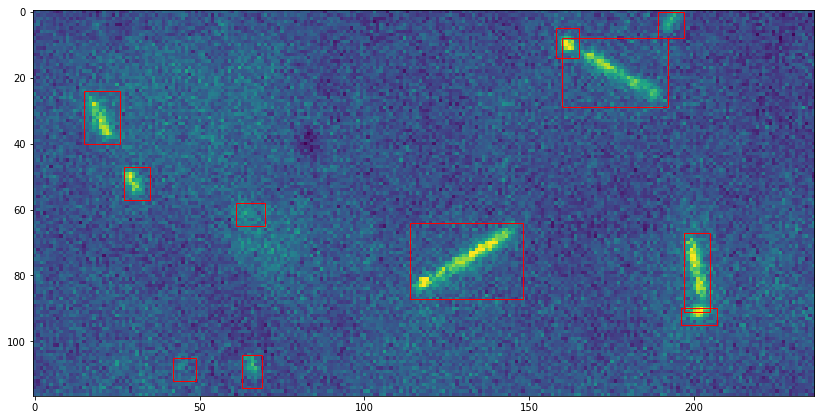

In [8]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(14, 8))

ax.imshow(original_image)

for i, roi in enumerate(postprocessing_results["rois"]):
    y1, x1, y2, x2 = roi
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red")
    ax.add_artist(rect)